In [ ]:
from google.colab import drive
drive.mount("/content/drive")

!pip install ultralytics scikit-learn matplotlib pandas pyyaml -q

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.2 MB/s eta 0:00:00


In [ ]:
import torch
print("Using device:", "cuda" if torch.cuda.is_available() else "cpu")


Using device: cuda


In [ ]:
import os
import shutil
from glob import glob
from typing import List, Dict, Any, Optional

import yaml
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from ultralytics import YOLO
import zipfile



# Where we will write k-shot experiment datasets and results (local to Colab VM)
OUTPUT_DIR = "/content/drive/MyDrive/CS171_experiments"

# Class names for the Common Kitchen Utensils dataset
# (order must match the YOLO export; this is the 10-class list from Roboflow)
CLASSES: List[str] = [
    "bowl",
    "fork",
    "glass",
    "knife",
    "mug",
    "pan",
    "plate",
    "spatula",
    "spoon",
    "whisk",
]

# k-shot values to test (number of training images per class)
K_VALUES: List[int] = [1, 4, 16, 32]

# Fraction of the full pool reserved as a fixed test set
TEST_SIZE_RATIO: float = 0.2

# YOLO training hyperparameters
EPOCHS: int = 10
IMG_SIZE: int = 640
BATCH_SIZE: int = 16
NUM_WORKERS: int = 2

# Random seed for reproducibility
SEED: int = 42


# ========================= TRIAL AND ERROR RUN
# EXTRACT DATASET TO LOCAL STORAGE
# =========================

# Your zip file on Google Drive
ZIP_PATH = "/content/drive/MyDrive/CS-171 FInal Project/Common Kitchen Utensils.v2i.yolov8.zip"

# Extract to local Colab storage
LOCAL_DIR = "/content/dataset"

if not os.path.exists(LOCAL_DIR):
    print("Extracting dataset from zip...")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(LOCAL_DIR)
    print("Done!")

# Update SOURCE_DATA_DIR to use local extracted dataset
SOURCE_DATA_DIR = LOCAL_DIR

# =========================
# UTILITY FUNCTIONS
# =========================
# =========================
# UTILITY FUNCTIONS
# =========================

def set_global_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)

def infer_primary_class_id(label_path: str) -> Optional[int]:
    """
    This function reads a YOLO label file and returns the first class_id encountered.
    """
    if not os.path.exists(label_path):
        return None

    with open(label_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            try:
                return int(parts[0])
            except ValueError:
                continue
    return None

def copy_subset(df: pd.DataFrame, split_dir: str) -> None:
    """ This fucntion copies a subset of images and labels to a specified directory. """
    images_dir = os.path.join(split_dir, "images")
    labels_dir = os.path.join(split_dir, "labels")
    ensure_dir(images_dir)
    ensure_dir(labels_dir)

    for _, row in df.iterrows():
        img_src = row["image"]
        lbl_src = row["label"]
        img_dst = os.path.join(images_dir, os.path.basename(img_src))
        lbl_dst = os.path.join(labels_dir, os.path.basename(lbl_src))
        shutil.copy2(img_src, img_dst)
        shutil.copy2(lbl_src, lbl_dst)

print("Configuration and utility functions loaded.")
print("SOURCE_DATA_DIR:", SOURCE_DATA_DIR)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Extracting dataset from zip...
Done!
Configuration and utility functions loaded.
SOURCE_DATA_DIR: /content/dataset


In [ ]:
def index_master_dataset(source_dir: str) -> pd.DataFrame:
    """ This function indexes the master dataset.
    """
    splits = ["train", "valid", "test"]
    all_images: List[str] = []

    for split in splits:
        split_images_dir = os.path.join(source_dir, split, "images")
        for pattern in ["*.jpg", "*.jpeg", "*.png"]:
            all_images.extend(glob(os.path.join(split_images_dir, pattern)))

    if not all_images:
        raise RuntimeError(f"No images found under {source_dir}. Check SOURCE_DATA_DIR and unzip path.")

    records: List[Dict[str, Any]] = []
    for img_path in all_images:
        # Map image path to label path in the same split
        label_path = img_path.replace(os.sep + "images" + os.sep,
                                      os.sep + "labels" + os.sep)
        label_path = os.path.splitext(label_path)[0] + ".txt"

        class_id = infer_primary_class_id(label_path)
        if class_id is None:
            # Skip images without valid labels
            continue

        records.append(
            {
                "image": img_path,
                "label": label_path,
                "class_id": class_id,
            }
        )

    if not records:
        raise RuntimeError("No valid (image, label) pairs found in the dataset.")

    df = pd.DataFrame(records)
    print(f"Indexed {len(df)} labeled images across all splits.")
    print("Class distribution:\n", df["class_id"].value_counts().sort_index())
    return df


def create_k_shot_datasets(
    source_dir: str,
    output_dir: str,
    classes: List[str],
    k_values: List[int],
    test_size_ratio: float,
    seed: int,
) -> None:
    """Create k-shot datasets for each k in k_values.

    - Build a single master DataFrame of all labeled images.
    - Split once into train/val pool vs fixed test set (stratified).
    - For each k, sample k images per class for training and
      use the remaining train/val pool as validation.
    - Write a YOLO-style directory tree and data.yaml per k.
    """
    set_global_seed(seed)

    print("Indexing master dataset...")
    df = index_master_dataset(source_dir)

    trainval_df, test_df = train_test_split(
        df,
        test_size=test_size_ratio,
        stratify=df["class_id"],
        random_state=seed,
    )

    print(f"Train/Val pool: {len(trainval_df)} images")
    print(f"Test set:       {len(test_df)} images\n")

    for k in k_values:
        print(f"=== Building dataset for k={k} images per class ===")

        def sample_k(group: pd.DataFrame) -> pd.DataFrame:
            n = min(k, len(group))
            if n < k:
                print(
                    f"  [WARN] Class {group.name} has only {len(group)} images; "
                    f"using {n} instead of requested {k}."
                )
            return group.sample(n=n, random_state=seed)

        # k-shot training subset
        train_df_k = trainval_df.groupby("class_id", group_keys=False).apply(sample_k)

        # Remaining images become validation for this k
        val_df_k = trainval_df.drop(train_df_k.index)

        exp_path = os.path.join(output_dir, f"yolo_k{k}")
        train_dir = os.path.join(exp_path, "train")
        val_dir = os.path.join(exp_path, "val")
        test_dir = os.path.join(exp_path, "test")

        # Clean and recreate directory
        if os.path.exists(exp_path):
            shutil.rmtree(exp_path)
        ensure_dir(exp_path)

        print(f"  Copying train subset ({len(train_df_k)} images)...")
        copy_subset(train_df_k, train_dir)

        print(f"  Copying val subset ({len(val_df_k)} images)...")
        copy_subset(val_df_k, val_dir)

        print(f"  Copying test subset ({len(test_df)} images)...")
        copy_subset(test_df, test_dir)

        # Write data.yaml
        data_yaml = {
            "path": exp_path,
            "train": "train/images",
            "val": "val/images",
            "test": "test/images",
            "nc": len(classes),
            "names": classes,
        }
        with open(os.path.join(exp_path, "data.yaml"), "w") as f:
            yaml.safe_dump(data_yaml, f)

        print(f"  Wrote data.yaml at: {os.path.join(exp_path, 'data.yaml')}\n")

    print("All k-shot datasets created successfully.")


# Run once after setting SOURCE_DATA_DIR correctly
create_k_shot_datasets(
    source_dir=SOURCE_DATA_DIR,
    output_dir=OUTPUT_DIR,
    classes=CLASSES,
    k_values=K_VALUES,
    test_size_ratio=TEST_SIZE_RATIO,
    seed=SEED,
)


Indexing master dataset...
Indexed 8005 labeled images across all splits.
Class distribution:
 class_id
0    807
1    816
2    496
3    892
4    945
5    859
6    820
7    895
8    772
9    703
Name: count, dtype: int64
Train/Val pool: 6404 images
Test set:       1601 images

=== Building dataset for k=1 images per class ===
  Copying train subset (10 images)...


/tmp/ipython-input-4057892008.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_k = trainval_df.groupby("class_id", group_keys=False).apply(sample_k)


  Copying val subset (6394 images)...
  Copying test subset (1601 images)...
  Wrote data.yaml at: /content/drive/MyDrive/CS171_experiments/yolo_k1/data.yaml

=== Building dataset for k=4 images per class ===
  Copying train subset (40 images)...


/tmp/ipython-input-4057892008.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_k = trainval_df.groupby("class_id", group_keys=False).apply(sample_k)


  Copying val subset (6364 images)...
  Copying test subset (1601 images)...
  Wrote data.yaml at: /content/drive/MyDrive/CS171_experiments/yolo_k4/data.yaml

=== Building dataset for k=16 images per class ===
  Copying train subset (160 images)...


/tmp/ipython-input-4057892008.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_k = trainval_df.groupby("class_id", group_keys=False).apply(sample_k)


  Copying val subset (6244 images)...
  Copying test subset (1601 images)...
  Wrote data.yaml at: /content/drive/MyDrive/CS171_experiments/yolo_k16/data.yaml

=== Building dataset for k=32 images per class ===
  Copying train subset (320 images)...


/tmp/ipython-input-4057892008.py:103: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df_k = trainval_df.groupby("class_id", group_keys=False).apply(sample_k)


  Copying val subset (6084 images)...
  Copying test subset (1601 images)...
  Wrote data.yaml at: /content/drive/MyDrive/CS171_experiments/yolo_k32/data.yaml

All k-shot datasets created successfully.


In [ ]:
import time

# The only thing that changes across experiments is the number of training
# images per class (k), not which images we evaluate on.
def train_and_evaluate_yolo_k(
    output_dir: str,
    k_values: List[int],
    epochs: int,
    img_size: int,
    batch_size: int,
    num_workers: int,
    seed: int,
) -> pd.DataFrame:
    set_global_seed(seed)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"\nUsing device: {device}")

    results_log: Dict[str, List[float]] = {
        "k": [],
        "num_train_images": [],
        "num_val_images": [],
        "num_test_images": [],
        "mAP50": [],
        "mAP50-95": [],
        "train_time_sec": [],
    }

    runs_dir = os.path.join(output_dir, "runs_yolo_k")
    ensure_dir(runs_dir)

    for k in k_values:
        print(f"\n🚀 STARTING TRAINING FOR k={k} images per class 🚀")

        exp_path = os.path.join(output_dir, f"yolo_k{k}")
        data_yaml_path = os.path.join(exp_path, "data.yaml")
        if not os.path.exists(data_yaml_path):
            raise FileNotFoundError(
                f"data.yaml for k={k} not found at {data_yaml_path}. "
                "Did you run create_k_shot_datasets()?"
            )

        # Count images per split for reporting
        num_train_images = len(glob(os.path.join(exp_path, "train", "images", "*")))
        num_val_images = len(glob(os.path.join(exp_path, "val", "images", "*")))
        num_test_images = len(glob(os.path.join(exp_path, "test", "images", "*")))

        print(f"  Train images: {num_train_images}")
        print(f"  Val images:   {num_val_images}")
        print(f"  Test images:  {num_test_images}")

        # Load base COCO-pretrained model (small, fast)
        model = YOLO("yolov8n.pt")

        train_run_name = f"train_k{k}"

        start_time = time.time()
        model.train(
            data=data_yaml_path,
            epochs=epochs,
            imgsz=img_size,
            batch=batch_size,
            device=device,
            project=runs_dir,
            name=train_run_name,
            seed=seed,
            workers=num_workers,
        )
        train_time_sec = time.time() - start_time
        print(f"  Training time for k={k}: {train_time_sec/60:.2f} minutes")

        # Path to best weights
        best_weights_path = os.path.join(runs_dir, train_run_name, "weights", "best.pt")
        if not os.path.exists(best_weights_path):
            raise FileNotFoundError(
                f"best.pt not found at {best_weights_path}. Check your YOLO training run."
            )

        print(f"  Evaluating best model for k={k} on test split...")
        best_model = YOLO(best_weights_path)
        metrics = best_model.val(data=data_yaml_path, split="test", device=device)

        mAP50 = float(metrics.box.map50)
        mAP50_95 = float(metrics.box.map)

        results_log["k"].append(k)
        results_log["num_train_images"].append(num_train_images)
        results_log["num_val_images"].append(num_val_images)
        results_log["num_test_images"].append(num_test_images)
        results_log["mAP50"].append(mAP50)
        results_log["mAP50-95"].append(mAP50_95)
        results_log["train_time_sec"].append(train_time_sec)

        print(
            f"✅ Finished k={k}: mAP@0.5 = {mAP50:.4f}, "
            f"mAP@0.5:0.95 = {mAP50_95:.4f}"
        )

    results_df = pd.DataFrame(results_log).sort_values("k").reset_index(drop=True)
    results_csv_path = os.path.join(output_dir, "yolo_k_results.csv")
    results_df.to_csv(results_csv_path, index=False)
    print(f"\nSaved results to: {results_csv_path}")
    print("Final aggregated results:\n", results_df)

    return results_df


results_df = train_and_evaluate_yolo_k(
    output_dir=OUTPUT_DIR,
    k_values=K_VALUES,
    epochs=EPOCHS,
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    seed=SEED,
)



Using device: cuda

🚀 STARTING TRAINING FOR k=1 images per class 🚀
  Train images: 10
  Val images:   6394
  Test images:  1601
Ultralytics 8.3.240 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/CS171_experiments/yolo_k1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_


==== YOLO-k Results Table ====
    k  num_train_images  num_val_images  num_test_images     mAP50  mAP50-95  \
0   1                10            6394             1601  0.030309  0.015484   
1   4                40            6364             1601  0.083159  0.042716   
2  16               160            6244             1601  0.317308  0.192453   
3  32               320            6084             1601  0.459880  0.277976   

   train_time_sec  train_time_min  
0      919.874728       15.331245  
1      915.043727       15.250729  
2      938.527819       15.642130  
3      951.699488       15.861658  


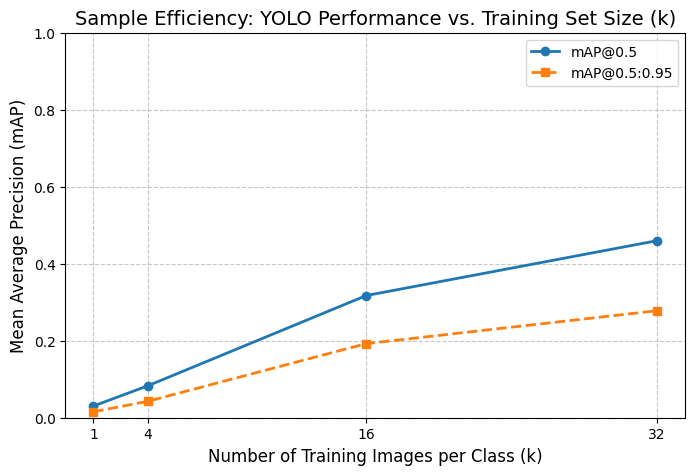

Saved mAP vs k plot to: /content/drive/MyDrive/CS171_experiments/rq2_sample_efficiency.png


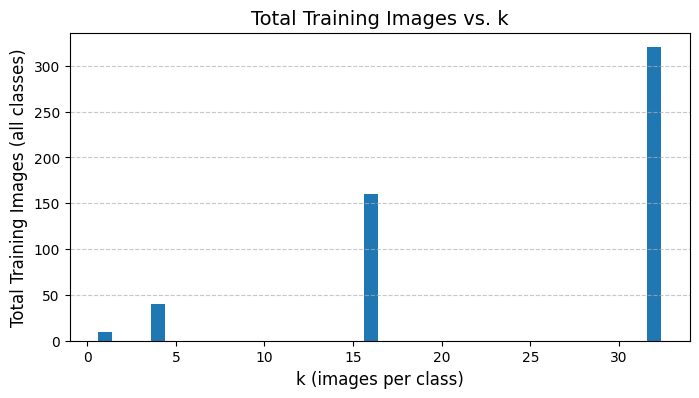

Saved training image count plot to: /content/drive/MyDrive/CS171_experiments/rq2_train_counts.png


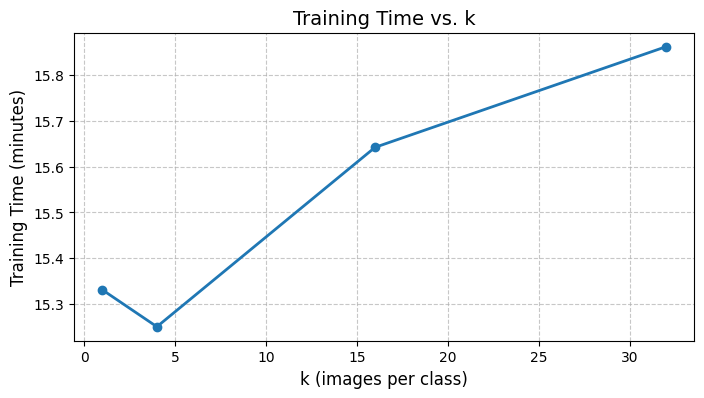

Saved training time plot to: /content/drive/MyDrive/CS171_experiments/rq2_train_time.png


In [ ]:
def plot_sample_efficiency(results_df: pd.DataFrame, k_values: List[int], output_dir: str) -> None:
    # Ensure sorted by k
    results_df = results_df.sort_values("k").reset_index(drop=True)

    # Add minutes column for convenience
    results_df["train_time_min"] = results_df["train_time_sec"] / 60.0

    print("\n==== YOLO-k Results Table ====")
    print(results_df)

    # 1) Plot mAP vs k
    plt.figure(figsize=(8, 5))
    plt.plot(results_df["k"], results_df["mAP50"], marker="o", linewidth=2, label="mAP@0.5")
    plt.plot(results_df["k"], results_df["mAP50-95"], marker="s", linestyle="--", linewidth=2, label="mAP@0.5:0.95")
    plt.title("Sample Efficiency: YOLO Performance vs. Training Set Size (k)", fontsize=14)
    plt.xlabel("Number of Training Images per Class (k)", fontsize=12)
    plt.ylabel("Mean Average Precision (mAP)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.xticks(results_df["k"])
    plt.legend()
    plt.ylim(0.0, 1.0)

    out_path_curve = os.path.join(output_dir, "rq2_sample_efficiency.png")
    plt.savefig(out_path_curve, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved mAP vs k plot to: {out_path_curve}")

    # 2) Plot number of training images vs k
    plt.figure(figsize=(8, 4))
    plt.bar(results_df["k"], results_df["num_train_images"])
    plt.title("Total Training Images vs. k", fontsize=14)
    plt.xlabel("k (images per class)", fontsize=12)
    plt.ylabel("Total Training Images (all classes)", fontsize=12)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    out_path_counts = os.path.join(output_dir, "rq2_train_counts.png")
    plt.savefig(out_path_counts, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved training image count plot to: {out_path_counts}")

    # 3) Plot training time vs k
    plt.figure(figsize=(8, 4))
    plt.plot(results_df["k"], results_df["train_time_min"], marker="o", linewidth=2)
    plt.title("Training Time vs. k", fontsize=14)
    plt.xlabel("k (images per class)", fontsize=12)
    plt.ylabel("Training Time (minutes)", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.7)

    out_path_time = os.path.join(output_dir, "rq2_train_time.png")
    plt.savefig(out_path_time, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved training time plot to: {out_path_time}")


plot_sample_efficiency(results_df, K_VALUES, OUTPUT_DIR)


In [ ]:
import os

# Folder in Drive to store all experiment outputs
SAVE_ROOT = "/content/drive/MyDrive/CS171_experiments"
os.makedirs(SAVE_ROOT, exist_ok=True)

# Copy the entire experiments directory into Drive
!cp -r /content/experiments "$SAVE_ROOT/experiments"

print("Copied /content/experiments to:", SAVE_ROOT)
print("Contents now:", os.listdir(SAVE_ROOT))


cp: cannot stat '/content/experiments': No such file or directory
Copied /content/experiments to: /content/drive/MyDrive/CS171_experiments
Contents now: ['yolo_coco_zero_shot_results.csv', 'owlvit_zero_shot_results.csv', 'yolo_k1', 'yolo_k4', 'yolo_k16', 'yolo_k32', 'runs_yolo_k', 'yolo_k_results.csv', 'rq2_sample_efficiency.png', 'rq2_train_counts.png', 'rq2_train_time.png']


In [ ]:
KEY_DIR = "/content/drive/MyDrive/CS171_experiments/key_artifacts"
os.makedirs(KEY_DIR, exist_ok=True)

!cp /content/experiments/yolo_k_results.csv "$KEY_DIR/"
!cp /content/experiments/rq2_*.png "$KEY_DIR/"  # main k-YOLO plots
!cp /content/experiments/best_k*_per_class_AP.png "$KEY_DIR/"

print("Key artifacts saved to:", KEY_DIR)
print("Files:", os.listdir(KEY_DIR))


cp: cannot stat '/content/experiments/yolo_k_results.csv': No such file or directory
cp: cannot stat '/content/experiments/rq2_*.png': No such file or directory
cp: cannot stat '/content/experiments/best_k*_per_class_AP.png': No such file or directory
Key artifacts saved to: /content/drive/MyDrive/CS171_experiments/key_artifacts
Files: []
